### NetID: sh2432

# Autoencoders

This code includes implementations of various simple autoencoders using the Keras front end to TensorFlow.
You should first run all of the code on the MNIST data, and gain a basic understanding of what everything is doing. 
Then, carry out the simple experiments described in Problem 2 of the assignment. For 2(b) (15 points), you need to run everything on the Fashion MNIST data and fill in the cells marked _your documentation/description goes here_ with documentation of the code or descriptions of the results. You should also include more plots of images and weights, as described in the assignment writeup. For 2(c) (10 points) you will fit a series of networks, varying the dimension of the bottleneck.

The starter code for this assignment is from [https://github.com/ardendertat/Applied-Deep-Learning-with-Keras](https://github.com/ardendertat/Applied-Deep-Learning-with-Keras). For Keras documentation, see [https://keras.io](https://keras.io).



## Problem 2 (a) Gradients for a simple autoencoder (5 points)

Calculate the gradients of a simple autoencoder, as described in the pdf assignment.


## Problem 2 (b) Run on Fashion MNIST (15 points)

Run all of the code below, first on MNIST, then change the data set to Fashion MNIST. Comment on what all of the code does and your findings, as indicated below.


In [14]:
from __future__ import print_function
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam

## Utility functions

this section difines a function that compare the original images with the reconstructed images and plot them out. the autiencoder learn (automatically) a lossy compression based on the test data fed in. So the compression is specific to those test data. n is the number of images shown for each row. dims defines the size of each image. All images shown are from the test data.

In [15]:
def plot_autoencoder_outputs(autoencoder, n, dims):
    decoded_imgs = autoencoder.predict(x_test)

    # number of example digits to show
    plt.figure(figsize=(2*n, 4.5))
    for i in range(n):
        # plot original image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Original Images')

        # plot reconstruction 
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Reconstructed Images')
    plt.show()


## Read the data
This section read the required dataset in (MNIST or Fashion_MNIST) and separate them into training and testing datasets. reshape the datasets into array with data type of float32 (single precision float: sign bit, 8 bits exponent, 23 bits mantissa) and print out the shape of training and testing datasets. Since 255.0 is the biggest number in the dataset, the numbers in the array will fall between 0 and 1.

In [45]:
#MNIST
#(x_train, y_train), (x_test, y_test) = mnist.load_data()
#Fashion_MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## Shallow autoencoder
This section conducts shallow autoencoder and fed the training datasets. It is a three layers net, i.e. a neural net with one hidden layer. The input and output size are the same 784, and we reconstruct the input using the adam optimizer and the binary crossentropy loss function. We have an undercomplete autoencoder as the hidden layer dimension (32) is smaller than the input (784). This constraint will impose our neural net to learn a compressed representation of data. 

reference: https://towardsdatascience.com/deep-inside-autoencoders-7e41f319999f

Then we print out 20 original images and their coresponding reconstructed images. And also calculate the weights of corresponding layers of each image.

In [46]:
input_size = 784
code_size = 32

input_img = Input(shape=(input_size,))
code = Dense(code_size, activation='relu')(input_img)
output_img = Dense(input_size, activation='sigmoid')(code)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 16s 269us/sample - loss: 0.3273
Epoch 2/5
60000/60000 [==============================] - 16s 262us/sample - loss: 0.2898
Epoch 3/5
60000/60000 [==============================] - 13s 214us/sample - loss: 0.2855
Epoch 4/5
60000/60000 [==============================] - 14s 229us/sample - loss: 0.2842
Epoch 5/5
60000/60000 [==============================] - 15s 246us/sample - loss: 0.2835


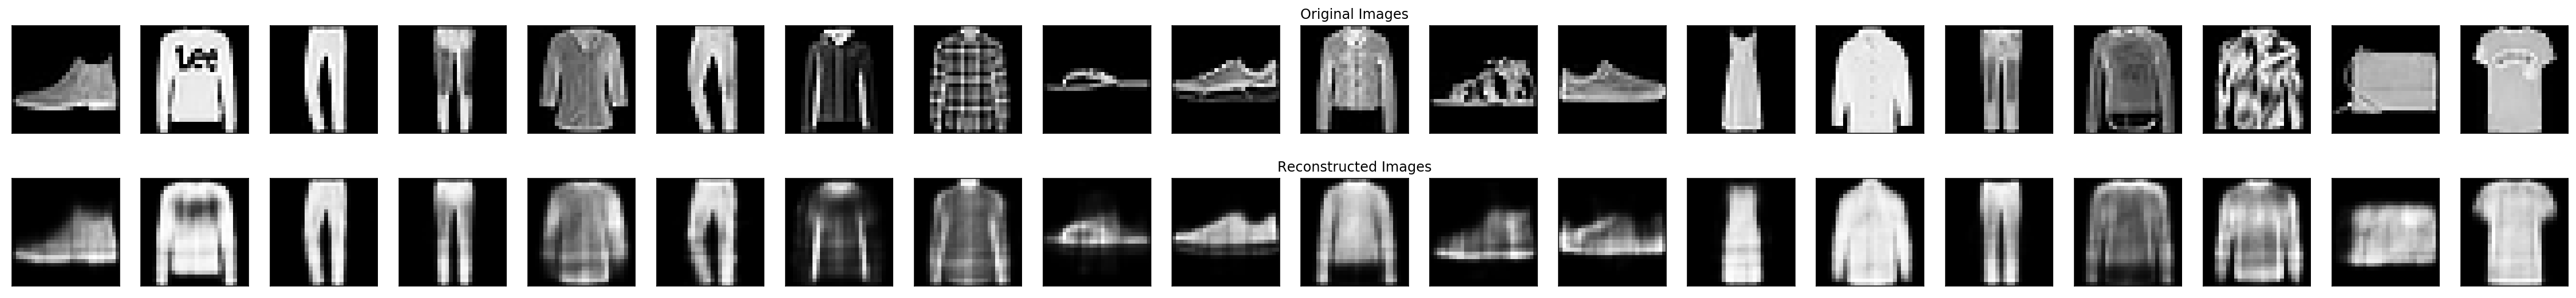

In [47]:
plot_autoencoder_outputs(autoencoder, 20, (28, 28))

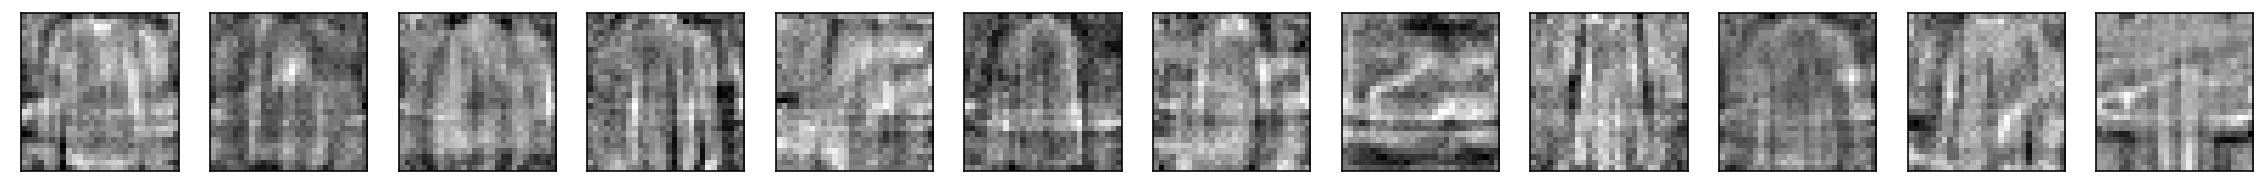

In [56]:
weights = autoencoder.get_weights()[0].T

n = 12
plt.figure(figsize=(20, 5))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(weights[i+20].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## Discussion of above results
In general, the shallow model did a good job in reconstructing the test images predicted using the model. The quality of the reconstructed image decreased in comparison to original, but the images are clearly visible. At least visually speaking, the test and the reconstructed images look similar but missing some details. For Fashion_MNIST, details of the cloths and shoes are missing, but the shape of the cloths and shoes are similar. For MNIST, the predictions are more similar and more clear since numbers are less complex. This model gives result of 71.65% accuracy rate which can be further improved by potentially adding more layers. Outputs of this shallow autoencoder model is similar with PCA decomposition model. The model can be improved by increasing the code size and adding more layers. The model is fully trained given the large sample size and the loss rate is stablized around 28%.

## Deep Autoencoder
This section conducts deep/multilayer autoencoder on training datasets. It uses 3 hidden layers instead of just one. Any of the hidden layers can be picked as the feature representation but we make the network symmetrical and use the middle-most layer. The input and output size are the same 784, and we reconstruct the input using the adam optimizer and the binary crossentropy loss function. We have two undercomplete autoencoders as the hidden layer dimensions (128 & 32) which are smaller than the input (784). This constraint will impose our neural net to learn a compressed representation of data.

reference: https://towardsdatascience.com/deep-inside-autoencoders-7e41f319999f

Then we print out 20 original images and their coresponding reconstructed images. And also calculate the weights of corresponding layers of each image.


In [57]:
input_size = 784
hidden_size = 128
code_size = 32
# encoder
input_img = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(input_img)
code = Dense(code_size, activation='relu')(hidden_1)
#decoder
hidden_2 = Dense(hidden_size, activation='relu')(code)
output_img = Dense(input_size, activation='sigmoid')(hidden_2)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 21s 342us/sample - loss: 0.3137
Epoch 2/10
60000/60000 [==============================] - 19s 316us/sample - loss: 0.2867
Epoch 3/10
60000/60000 [==============================] - 21s 345us/sample - loss: 0.2816
Epoch 4/10
60000/60000 [==============================] - 19s 325us/sample - loss: 0.2791
Epoch 5/10
60000/60000 [==============================] - 20s 334us/sample - loss: 0.2775
Epoch 6/10
60000/60000 [==============================] - 19s 309us/sample - loss: 0.2763
Epoch 7/10
60000/60000 [==============================] - 19s 318us/sample - loss: 0.2754
Epoch 8/10
60000/60000 [==============================] - 19s 310us/sample - loss: 0.2746
Epoch 9/10
60000/60000 [==============================] - 19s 325us/sample - loss: 0.2740
Epoch 10/10
60000/60000 [==============================] - 20s 331us/sample - loss: 0.2734


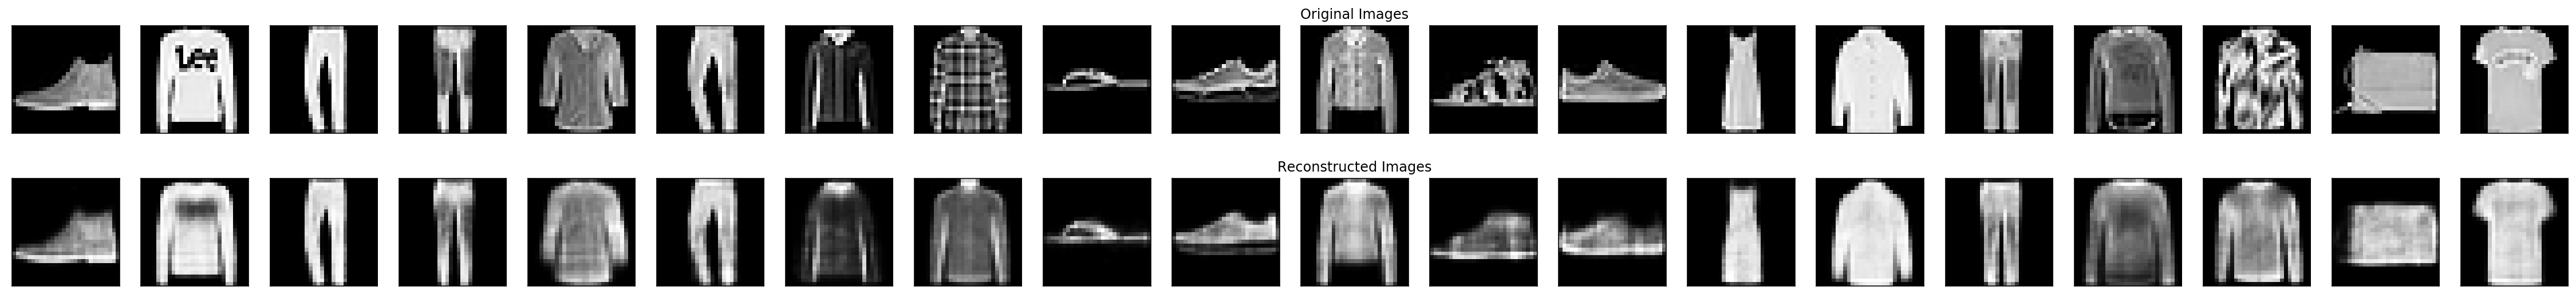

In [58]:
plot_autoencoder_outputs(autoencoder, 20, (28, 28))

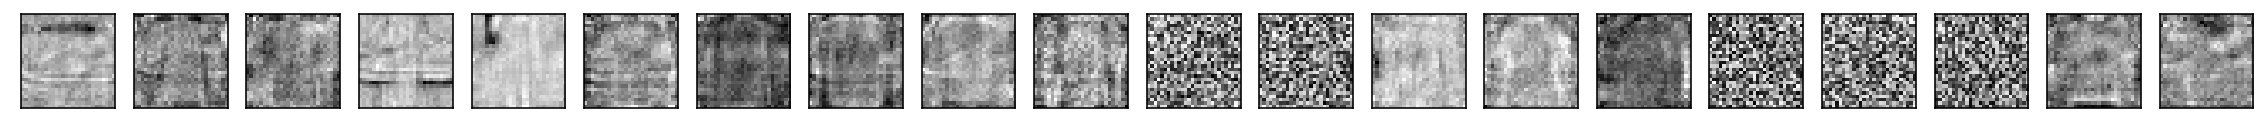

In [59]:
weights = autoencoder.get_weights()[0].T

n = 20
plt.figure(figsize=(20, 5))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(weights[i+0].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

## Discussion of above results
Adding hidden layers improve the accuracy of the prediction of the test images. It gives result of 72.66% accuracy rate which is better than the shallow model. The quality of the reconstructed image still decreased in comparison to original, but the images are more clearly visible. For Fashion_MNIST, details of the cloths and shoes are still missing, but the shape of the cloths and shoes are similar. Outputs of the deep autoencoder model better than shallow autoencoder model. The model can be further improved by increasing the code size and adding more layers. The model is fully trained given the large sample size and the loss rate is stablized around 27%.

## Denoising autoencoder
Rather than adding a penalty to the loss function, this section obtains an autoencoder that learns something useful by changing the reconstruction error term of the loss function. It is done by adding some noise of the input image and make the autoencoder learn to remove it. The encoder extracts the most important features and learn a robuster representation of the data. Then the code prints out 20 original images, their corresponding noisy images, the output images after the autoencoder process, and the weights of each image.

reference: https://towardsdatascience.com/deep-inside-autoencoders-7e41f319999f


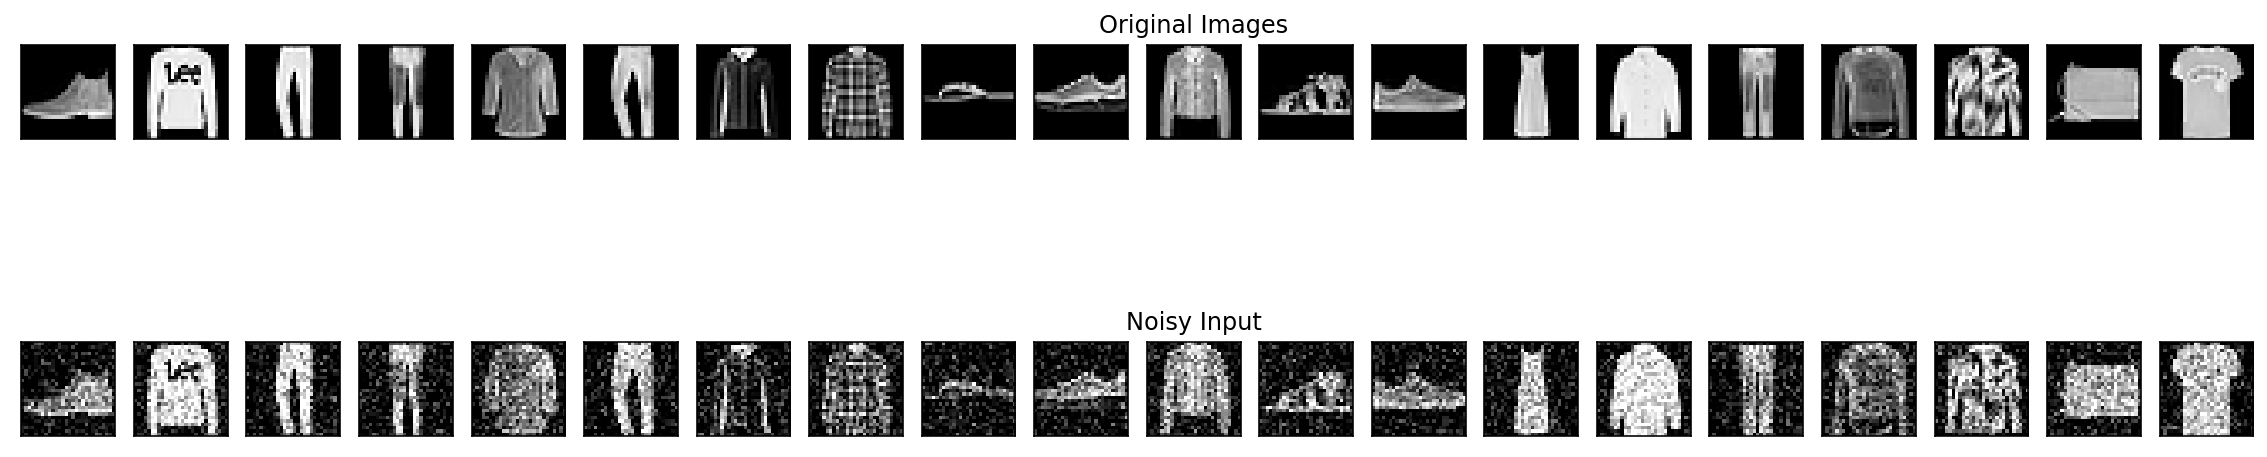

In [64]:
noise_factor = 0.20
x_train_noisy = x_train + noise_factor * np.random.normal(size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)

n = 20
plt.figure(figsize=(20, 5))
for i in range(n):
    # plot original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Original Images')

    # plot noisy image 
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Noisy Input')

In [65]:
input_size = 784
hidden_size = 128
code_size = 32

input_img = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(input_img)
code = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(code)
output_img = Dense(input_size, activation='sigmoid')(hidden_2)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train_noisy, x_train, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 17s 285us/sample - loss: 0.3185
Epoch 2/10
60000/60000 [==============================] - 16s 266us/sample - loss: 0.2923
Epoch 3/10
60000/60000 [==============================] - 16s 267us/sample - loss: 0.2870
Epoch 4/10
60000/60000 [==============================] - 16s 270us/sample - loss: 0.2844
Epoch 5/10
60000/60000 [==============================] - 16s 268us/sample - loss: 0.2829
Epoch 6/10
60000/60000 [==============================] - 16s 268us/sample - loss: 0.2818
Epoch 7/10
60000/60000 [==============================] - 16s 272us/sample - loss: 0.2810
Epoch 8/10
60000/60000 [==============================] - 16s 274us/sample - loss: 0.2805
Epoch 9/10
60000/60000 [==============================] - 17s 288us/sample - loss: 0.2800
Epoch 10/10
60000/60000 [==============================] - 16s 274us/sample - loss: 0.2796


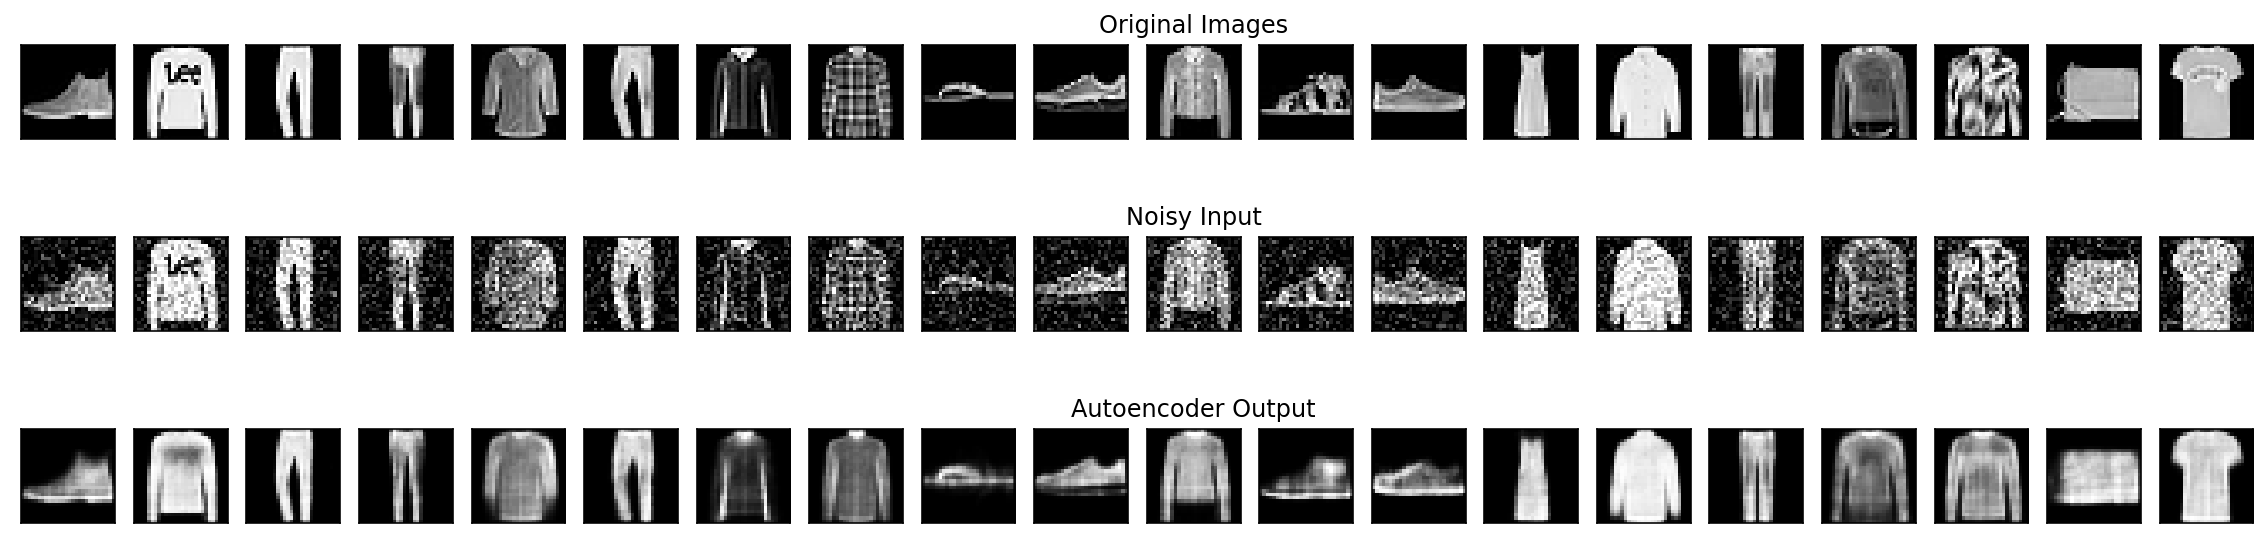

In [67]:
n = 20
plt.figure(figsize=(20, 5))

images = autoencoder.predict(x_test_noisy)

for i in range(n):
    # plot original image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Original Images')

    # plot noisy image 
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Noisy Input')
        
    # plot noisy image 
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Autoencoder Output')

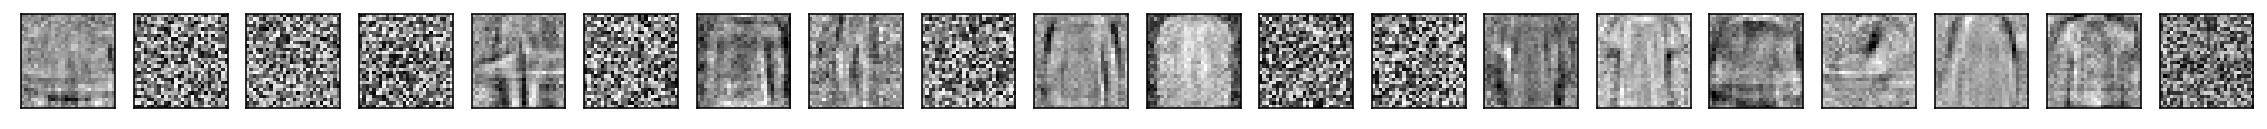

In [68]:
weights = autoencoder.get_weights()[0].T

n = 20
plt.figure(figsize=(20, 5))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(weights[i+0].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


## Discussion of above results
Denoising autoencoder adds noise to the images and then let the machine learn to remove noise. It gives result of 72.04% accuracy rate which is better than the shallow model, but a little bit worse than the deep autoencoder model. The quality of the reconstructed image decreased in comparison to original, but the images are clearly visible. For Fashion_MNIST, details of the cloths and shoes are missing, but the shape of the cloths and shoes are kept. The model can be further improved by increasing the code size and decrease the noise factor. The model is fully trained given the large sample size and the loss rate is stablized around 28%.

## Problem 2 (c): Training a series of shallow networks of varying complexity (10 points)

Your final task is to train a sequence of shallow networks, varying the code size parameter.
Plot the training error and test error as a function of the code size. Describing your findings. Interpret them in terms of the bias/variance tradeoff. 


In [114]:
loss=[]
val_loss=[]
for code_size in range(1, 784, 100):
    input_size = 784
    input_img = Input(shape=(input_size,))
    code = Dense(code_size, activation='relu')(input_img)
    output_img = Dense(input_size, activation='sigmoid')(code)
    autoencoder = Model(input_img, output_img)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    model = autoencoder.fit(x_train, x_train,epochs=5, verbose=1,validation_data=(x_test, x_test))
    l=model.history['loss'][4]
    v=model.history['val_loss'][4]

    loss.append(l)
    val_loss.append(v)
    
print(loss) 
print(val_loss)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 6s 105us/sample - loss: 0.4820 - val_loss: 0.4552
Epoch 2/5
60000/60000 [==============================] - 5s 82us/sample - loss: 0.4458 - val_loss: 0.4401
Epoch 3/5
60000/60000 [==============================] - 5s 82us/sample - loss: 0.4357 - val_loss: 0.4337
Epoch 4/5
60000/60000 [==============================] - 5s 84us/sample - loss: 0.4311 - val_loss: 0.4304
Epoch 5/5
60000/60000 [==============================] - 5s 83us/sample - loss: 0.4284 - val_loss: 0.4284
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 9s 145us/sample - loss: 0.3056 - val_loss: 0.2803
Epoch 2/5
60000/60000 [==============================] - 7s 124us/sample - loss: 0.2739 - val_loss: 0.2730
Epoch 3/5
60000/60000 [==============================] - 7s 122us/sample - loss: 0.2692 - val_loss: 0.2702
Epoch 4/5
60000/60000 [=========================

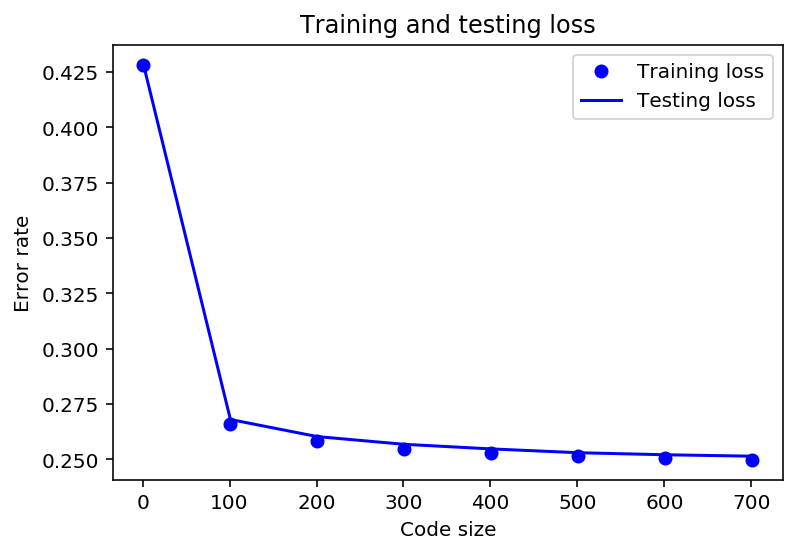

In [119]:
code_size = range(1, 784, 100)
plt.figure()
plt.plot(code_size, loss, 'bo', label='Training loss')
plt.plot(code_size, val_loss, 'b', label='Testing loss')
plt.title('Training and testing loss')
plt.xlabel('Code size')
plt.ylabel('Error rate')
plt.legend()
plt.show()

As code size increases, the error rate decreases. However, as shown in the graph, after code_size reachs 300, error rates of both training dataset and test dataset stablized around 0.25. Then increasing code_size will have little effect on improving the accuracy of the model. There is no bias/variance tradeoff observed in the plot though. The error rates keep decreasing. Maybe when the code_size become very large, the error rate will start to increase. 